In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans
import imageio

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import same_mov_inds, get_interp_filename
from tools_lnd import bifurc, plot_bifurc_ends, take_names, gen_mov_trial_set, make_D_use, gen_trials_from_model_dir
from tools_lnd import make_D_use, interp3d, take_names, comp_eig_decomp, axis_label_bifurc, title_label_bifurc
from tools_lnd import same_stim_trial, get_T_inds, gen_X_from_model_dir, check_plot_zero_plane, adjust_ax

In [9]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_trains_str = '_'.join(rule_trains)

rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'#'diag'
ruleset = 'all'
n_tasks = str(len(rule_trains))
n_rnn = str(128)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -7
seed = '1'
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder = 'data/rnn/multitask/stepnet/final'
m = os.path.join(p,data_folder,ruleset,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

In [10]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','movies')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [21]:
def bifurc_mov(m,D_use,rule_set,epoch_set,t_set = [0,0],script_name = 'interp_tasks_small_init_mov',
           cmap_grad = plt.get_cmap('plasma'),cmap_discrete = ['w','k'],q_thresh = .001,
           n_skip_interps=1, rule_axs = 0,ax_labels = 'pca_h', plot_unstable = True,
           color_stim = True,fig_size = 4, fontsize = 20, figpath = [],ruleset = [],
           title_y = .9, n_interp = 20,n_trials = 0, stability_thresh = 1, threeD = True,
           lims = [], view_ang = [],lw = 6,ms = 6,linestyle = '-',al_state = 1,al_fp = 1, 
           bifurc = True, plot_zero_plane = False, tol_q = 1e-6,plot_fps = True):
    
    LAG = 10 
    plt.rcParams.update({'font.size': fontsize})

    rule1 = rules_dict['all'][rule_set[0]]
    rule2 = rules_dict['all'][rule_set[1]]
    rule_str = [rule1,rule2]

    epoch = epoch_set[rule_axs]
    epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rules_dict['all'][rule_set[rule_axs]])
    epoch_name1, rule_name1, _, _ = take_names(epoch_set[0],rule1)
    epoch_name2, rule_name2, _, _ = take_names(epoch_set[1],rule2)

    if color_stim:
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
        trial2 = same_stim_trial(trial1, rule_set[1]) 
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    else:
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
        trial2 = gen_trials_from_model_dir(m,rule2,mode='test',noise_on = False)
        trial2 = same_mov_inds(trial1, trial2) 
        trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

    save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))
    filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)
    
    tit, tit_name, tit_save = title_label_bifurc(bifurc,epoch_name1,epoch_name2,rule_name1,
                                                 rule_name2,ruleset,title_y,fontsize)

    movie_dir = os.path.join(figpath,tit_save,tit_name,'ends')
    if not os.path.exists(movie_dir):
        os.makedirs(movie_dir)

    T_inds = get_T_inds(trial1,epoch_set[0])
    movie_inds = range(0,T_inds[-1]) #frame every 6 timesteps
    
    if plot_fps:
        mov_i = 33
        im_start = len(movie_inds)-1
    else:
        mov_i = 0
        im_start = 0
        
    for im_num in range(im_start,len(movie_inds),3):
        
        fig = plt.figure(figsize=(fig_size,fig_size),tight_layout=True,facecolor='white')
        if threeD:
            ax = fig.add_axes([0,0,1,1], projection='3d');
        else:
            ax = fig.add_axes([0,0,1,1]);

        axis_label_bifurc(ax,ax_labels,rule_name_ax,epoch_name_ax,bifurc,threeD,fontsize)    
        adjust_ax(ax,lims,threeD,bifurc,plot_zero_plane,view_ang)

        for ri in range(2):

            cd = cmap_discrete[ri]
            trial = gen_trials_from_model_dir(m,rule_str[ri],mode='test',noise_on = False)

        #plot trajectory
            if plot_fps:
                plot_set = T_inds
            else:   
                plot_set_start = np.max([movie_inds[0],im_num-LAG])
                plot_set = range(plot_set_start,im_num+1)

            #get traj
            _,x = gen_X_from_model_dir(m,trial)
            x_epoch = np.transpose(x,(1,2,0))

            #get state colors
            cmap_state = plt.get_cmap('hsv')
            if color_stim:
                c_set = np.min(trial.stim_locs[:,[0,2]],axis = 1)
                s = np.argwhere(c_set == np.min(trial1.stim_locs[t_set[0],[0,2]]))[0][0]
                c = cmap_state(c_set[s]/(2*np.pi))
            else:
                c_set = trial.y_loc[-1,:]
                s = np.argwhere(c_set==trial1.y_loc[-1,t_set[0]])[0][0]
                c = cmap_state(c_set[s]/(2*np.pi))

            #plot other trials   
            if n_trials==0:
                trial_set = range(0)
            else:
                trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/n_trials))

            for trial_i in trial_set:
                ci = cmap_state(c_set[trial_i]/(2*np.pi))
                x_traj_i = np.dot(x_epoch[trial_i,:,:],D_use)
                if bifurc:
                    x_traj_i[:,2] = x_traj_i[:,1]
                    x_traj_i[:,1] = x_traj_i[:,0]
                    x_traj_i[:,0] = ri*np.ones(len(x_traj_i))

                plot_bifurc(ax,x_traj_i,threeD,plot_set,c = ci,cd = cmap_discrete[ri],lw = lw*2,ms = ms)

#             #plot fp trial
#             x_traj = np.dot(x_epoch[s,:,:],D_use)
#             if bifurc:
#                 x_traj[:,2] = x_traj[:,1]
#                 x_traj[:,1] = x_traj[:,0]
#                 x_traj[:,0] = ri*np.ones(len(x_traj))

#             plot_bifurc(ax,x_traj, threeD, plot_set, c = c, cd = cmap_discrete[ri],lw = lw*2,ms = ms)

        mov_i += 1 
        plt.savefig(movie_dir +'/'+ str(mov_i) + '.png', dpi=300)


    #plot fps
    if plot_fps:
        for step_i in range(0,n_interp,n_skip_interps):
            c = cmap_grad(step_i/n_interp)

            fp_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)),
                                  filename_interp+'_step_'+str(step_i)+'.npz')
            fp_struct = np.load(fp_dir)
            fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]  
            J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
            sorted_fps = fp_struct['xstar'][fp_inds,:]
            eig_decomps = comp_eig_decomp(J_xstar)

            for fp_ind in range(len(fp_inds)):

                fp = np.dot(sorted_fps[fp_ind,:],D_use)
                facecolors_3d = c
                fp_s = 50

                if bifurc:
                    fp[2] = fp[1]
                    fp[1] = fp[0]
                    fp[0] = step_i/n_interp

                #sometimes we don't want to distinguish marginally stable fps so threshold is variable
                if np.max(eig_decomps[fp_ind]['evals'])>stability_thresh:
                    if plot_unstable:
                        #open circles for unstable
                        facecolors_3d = 'w'
                        if threeD:
                            ax.scatter(fp[0],fp[1],fp[2],s = fp_s,marker = 'o',edgecolors = c,
                               facecolors = facecolors_3d, linewidth = 1/3, alpha = al_fp)
                        else:
                            ax.scatter(fp[0],fp[1],s = fp_s+20,marker = 'o',edgecolors = c,
                               facecolors = facecolors_3d, linewidth = lw/2, alpha = al_fp)
                else:
                    if threeD:
                        ax.scatter(fp[0],fp[1],fp[2],s = fp_s,marker = 'o',edgecolors = c,
                               facecolors = facecolors_3d, linewidth = lw/3, alpha = al_fp)
                    else:
                        ax.scatter(fp[0],fp[1],s = fp_s+20,marker = 'o',edgecolors = c,
                               facecolors = facecolors_3d, linewidth = lw/3, alpha = al_fp)
                        
            mov_i += 1 
            plt.savefig(movie_dir +'/'+ str(mov_i) + '.png', dpi=300)
    
    if threeD:
        for turn in range(0,180,6):
            ax.view_init(elev=view_ang[0], azim=view_ang[1]+turn)    
            mov_i += 1 
            plt.savefig(movie_dir +'/'+ str(mov_i) + '.png', dpi=300)
        
    images = []
    for t in range(10,mov_i):
        filename = movie_dir +'/'+ str(t) + '.png'
        images.append(imageio.imread(filename))

    imageio.mimsave(movie_dir+'/movie.gif', images)

    return lims


In [22]:
def plot_bifurc(ax,x_traj_full,threeD,inds,linestyle = '-',c = 'r',cd = 'k',lw = 6,alpha = 1,ms = 6):

    x_traj = x_traj_full[inds,:]
    x_traj0 = x_traj_full[0,:]
    if threeD:

        for ind_i in (range(len(inds)-1)):
            ind_set = range(ind_i,len(x_traj))
            plt.plot(x_traj[ind_set,0],x_traj[ind_set,1],x_traj[ind_set,2],
                     linestyle,
                     c = c, 
                     linewidth = lw, 
                     alpha = .1, 
                     markersize = ms)
            
            plt.plot(x_traj[:,0],x_traj[:,1],x_traj[:,2],
                     linestyle,
                     c = cd, 
                     linewidth = lw/2, 
                     alpha = .1, 
                     markersize = ms)
    else:
            
        for ind_i in (range(len(inds)-1)):
            ind_set = range(ind_i,len(x_traj))
            plt.plot(x_traj[ind_set,0],x_traj[ind_set,1],
                     linestyle,
                     c = c, 
                     linewidth = lw, 
                     alpha = .1, 
                     markersize = ms)
            
            plt.plot(x_traj[:,0],x_traj[:,1],
                     linestyle,
                     c = cd, 
                     linewidth = lw/2, 
                     alpha = .1, 
                     markersize = ms)

In [23]:
q_thresh = 1e-8
tol_q = 1e-6
offset = 0
t_set = [offset, offset]
trial_num = [int(offset/4), int(offset/4)]
rule_axs = 0
rule_set = [13,14]
trial_set = gen_mov_trial_set(m,rule_set)
epoch_set = ['delay1','delay1']
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
ti = trial_num[rule_axs]

rule1 = rules_dict['all'][rule_set[0]]
rule2 = rules_dict['all'][rule_set[1]]
rule_str = [rule1,rule2]

ax_labels = 'pca_h'
D_fix = make_D_use(m,rule,'delay1',ti,ax_labels)
D_use = D_fix

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[rule_axs],rules_dict['all'][rule_set[rule_axs]])
ax_labels_master = [r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC1',
                    r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC2',
                    r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC3']

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

In [24]:
from tools_lnd import get_model_params
w_in, b_in, w_out, b_out = get_model_params(m)
D_use[:,2] = w_out[:,2]

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/15_tasks/128_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Doc

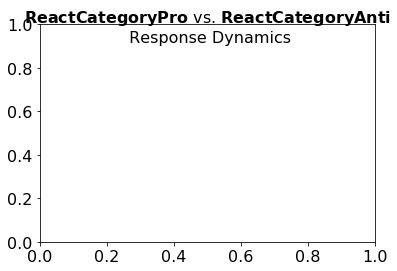

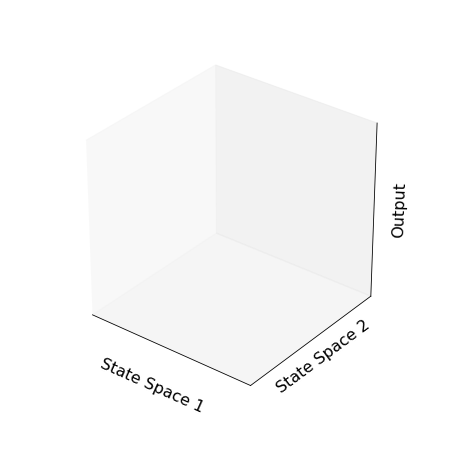

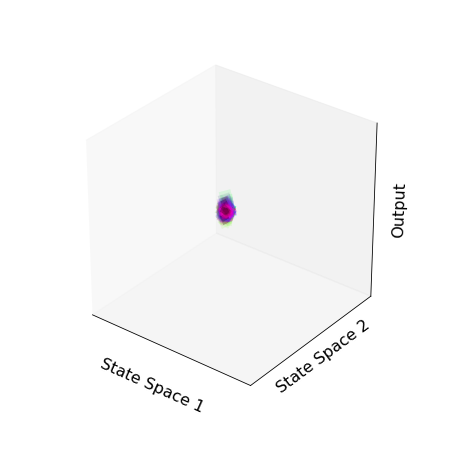

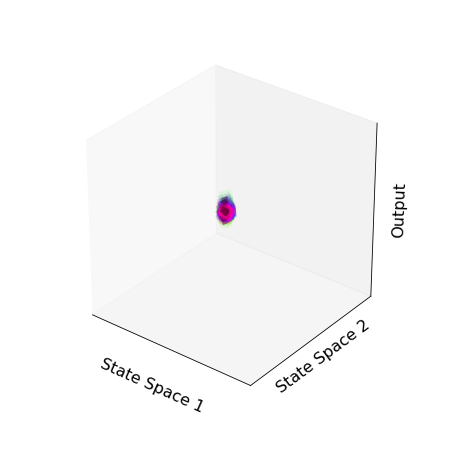

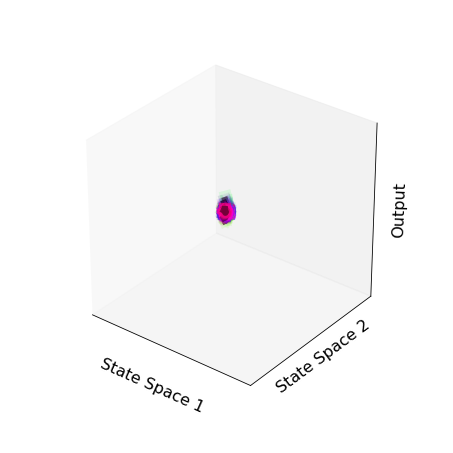

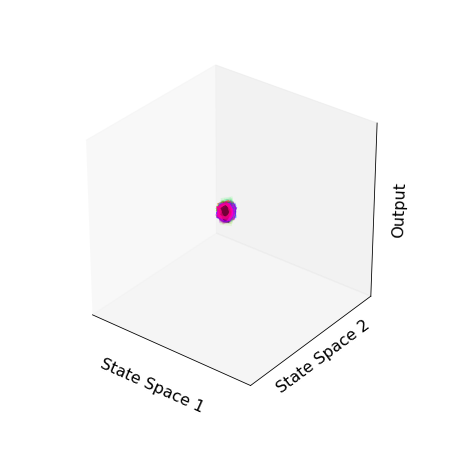

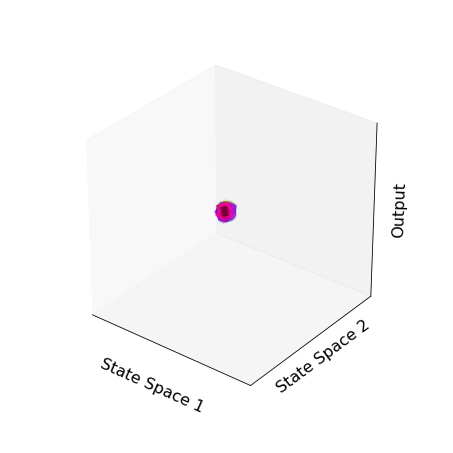

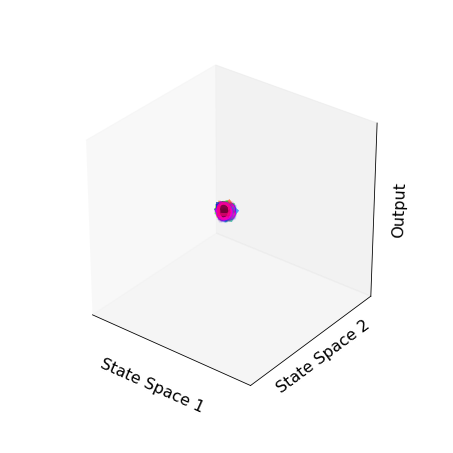

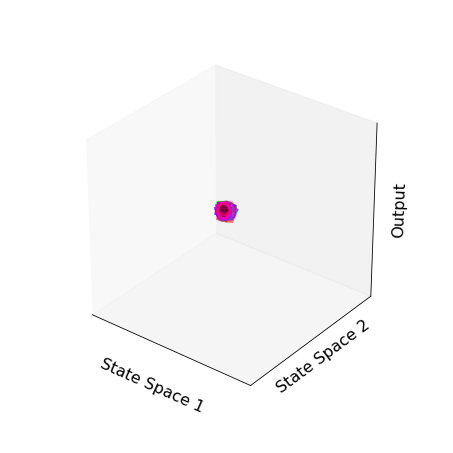

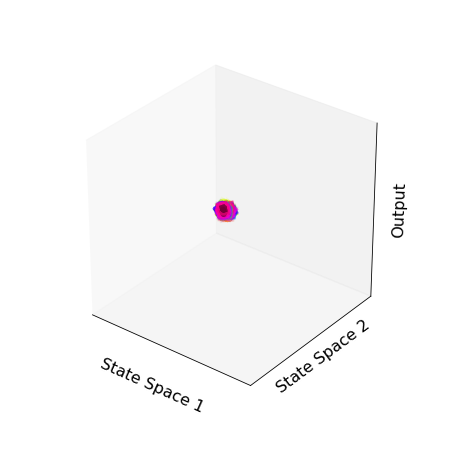

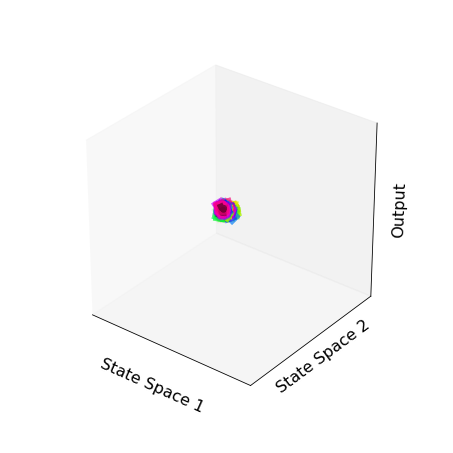

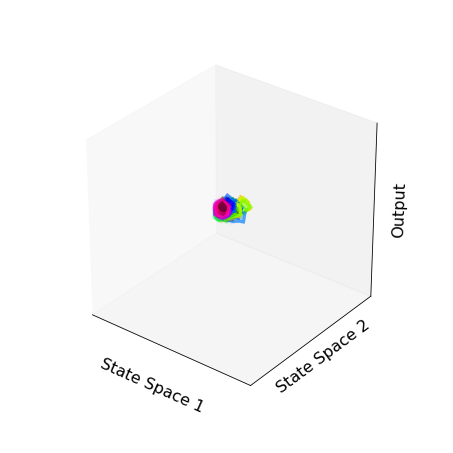

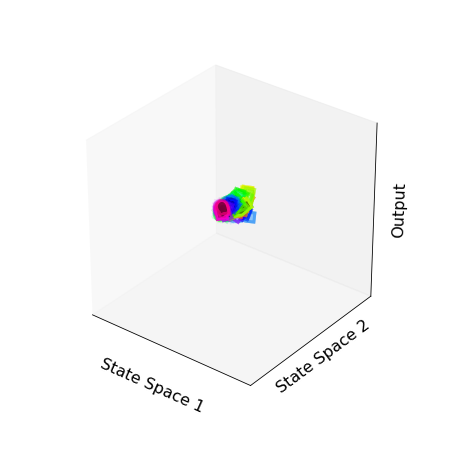

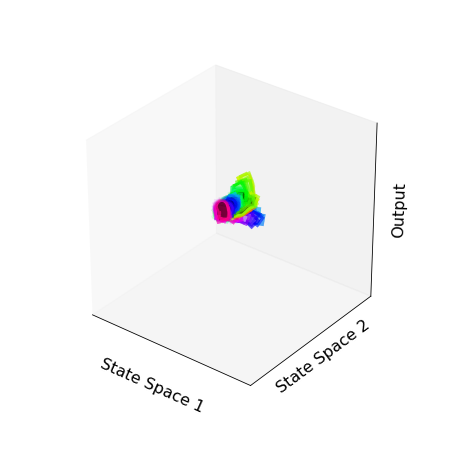

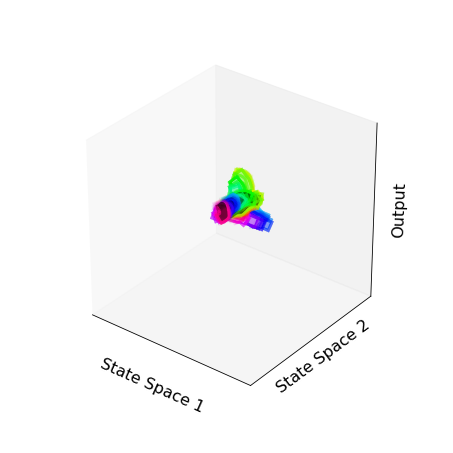

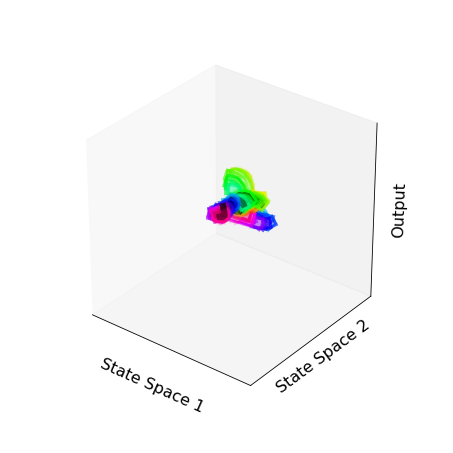

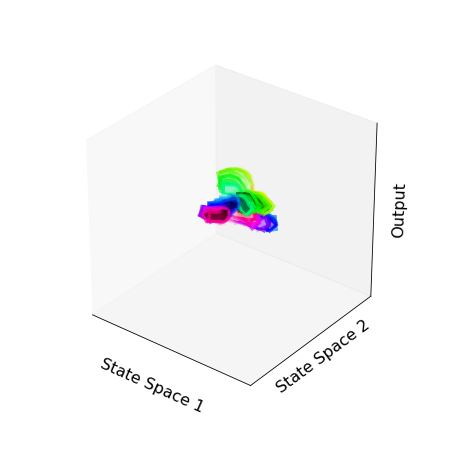

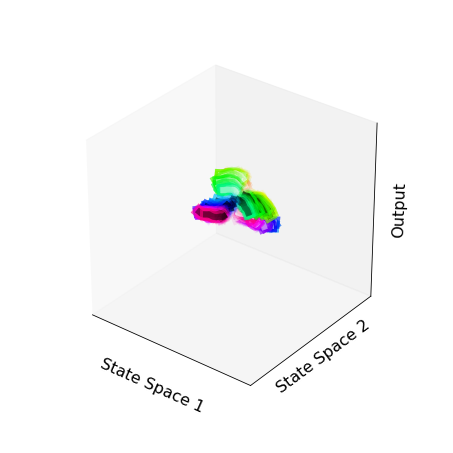

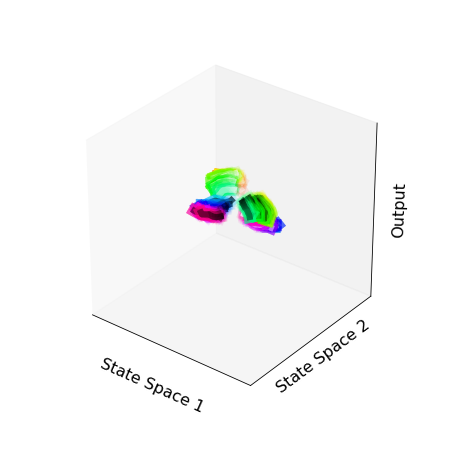

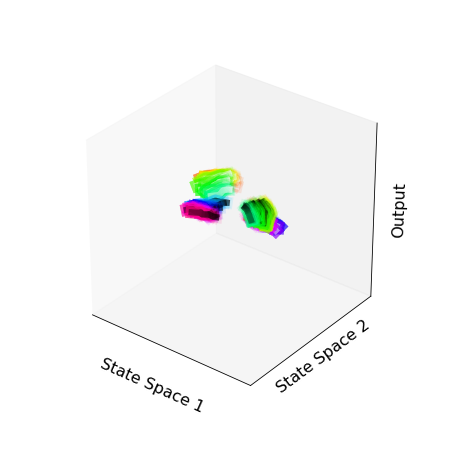

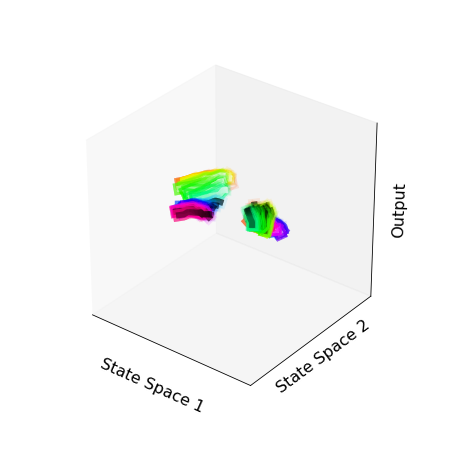

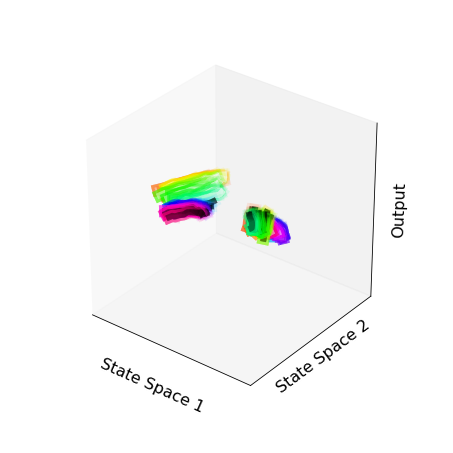

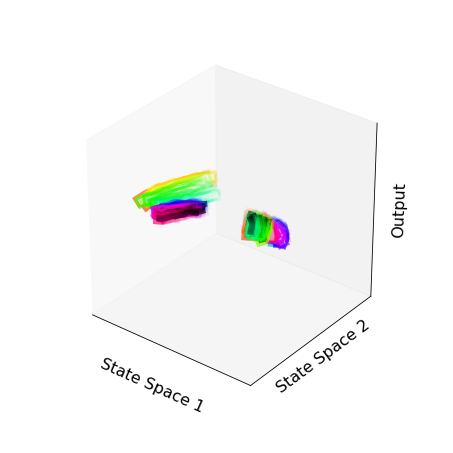

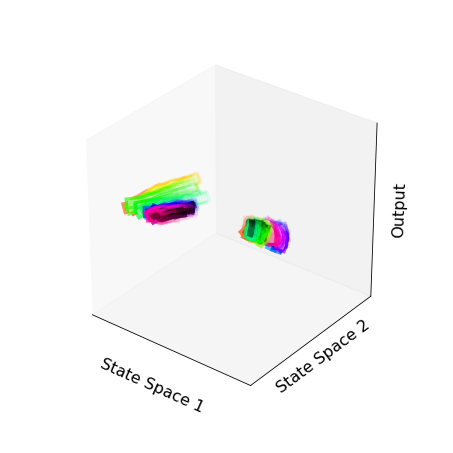

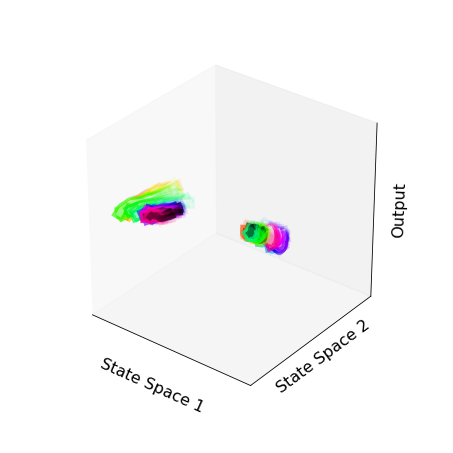

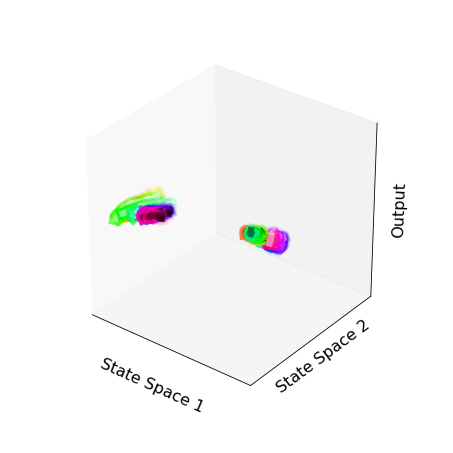

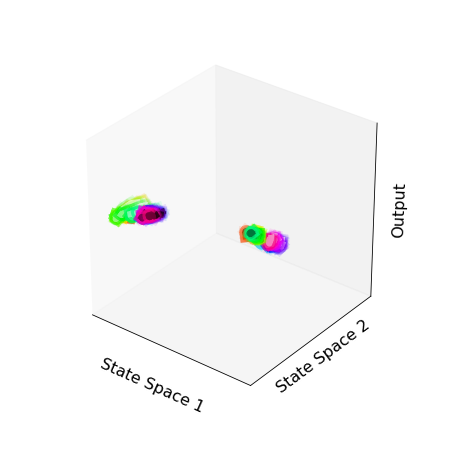

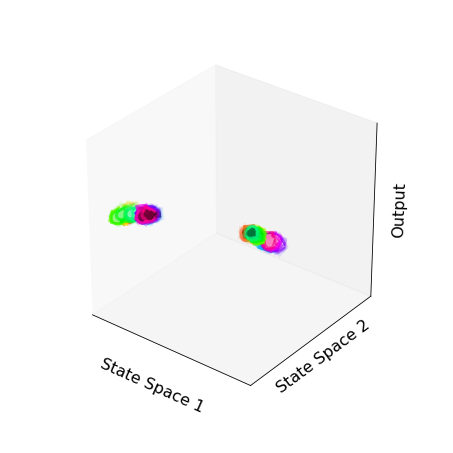

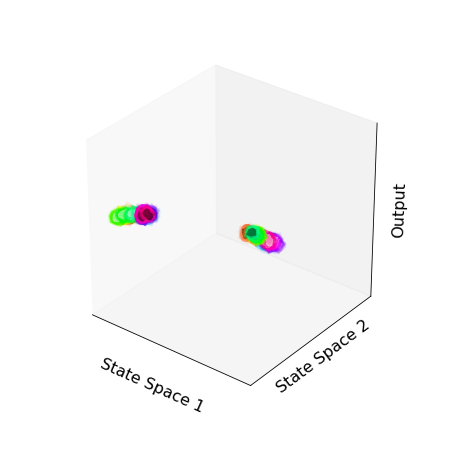

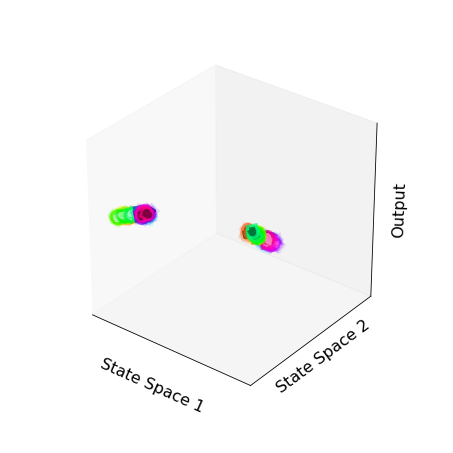

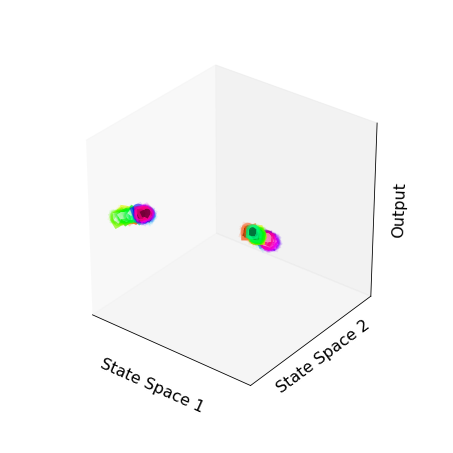

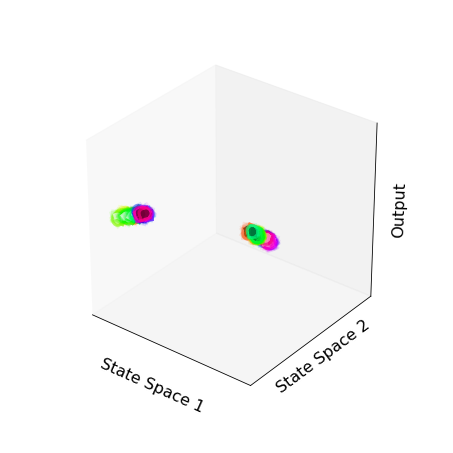

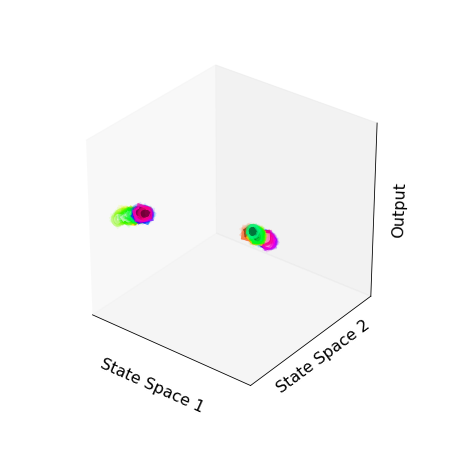

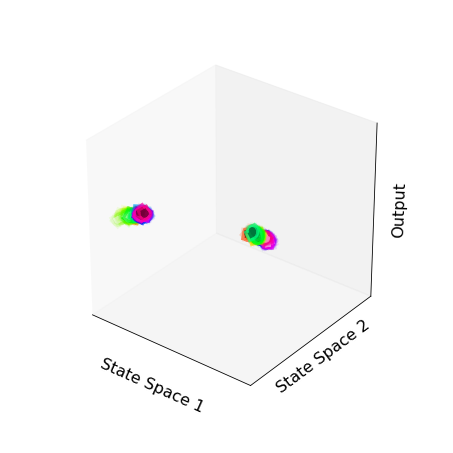

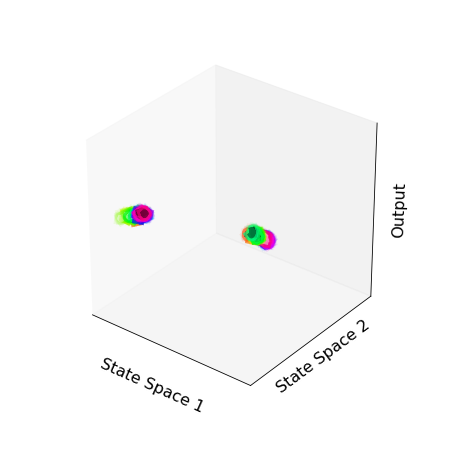

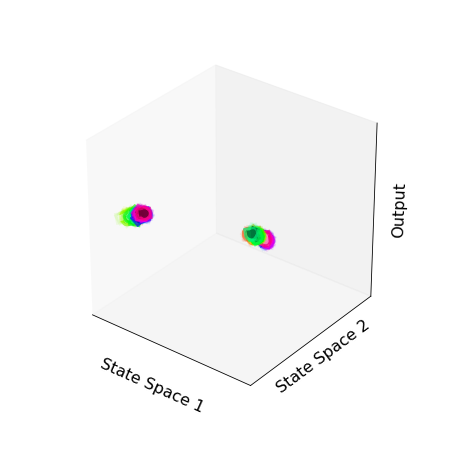

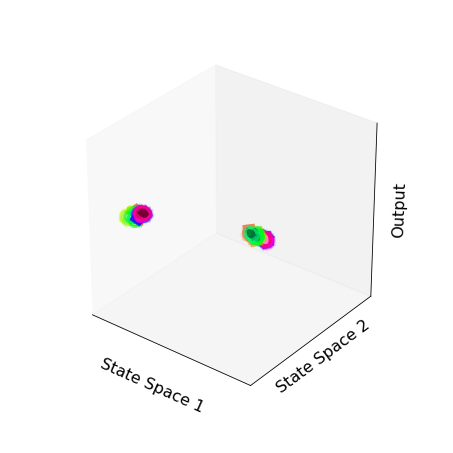

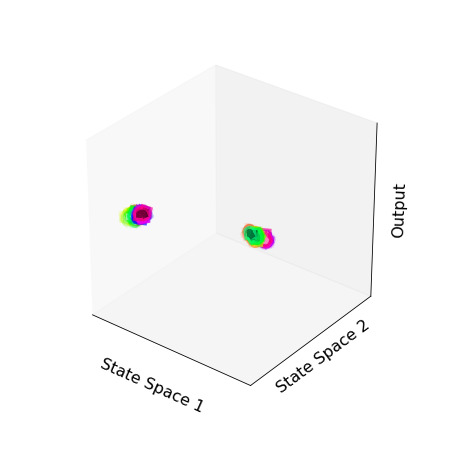

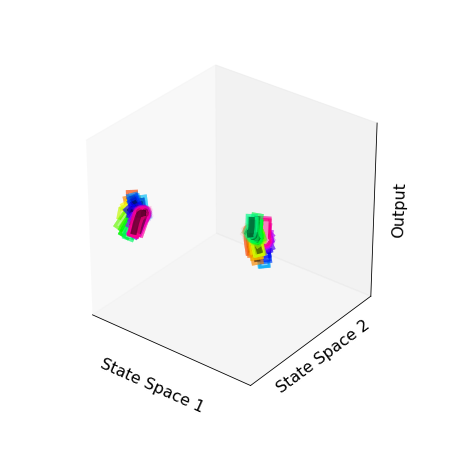

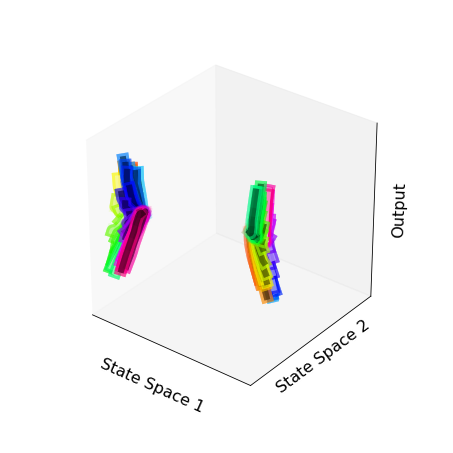

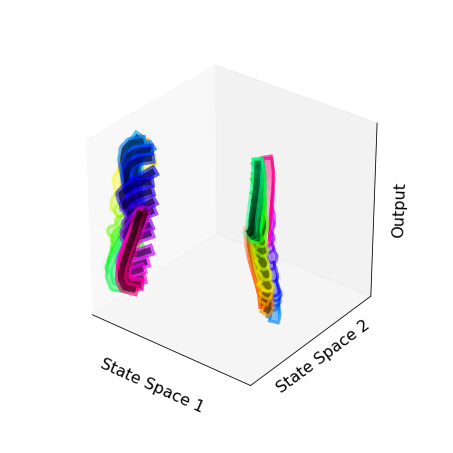

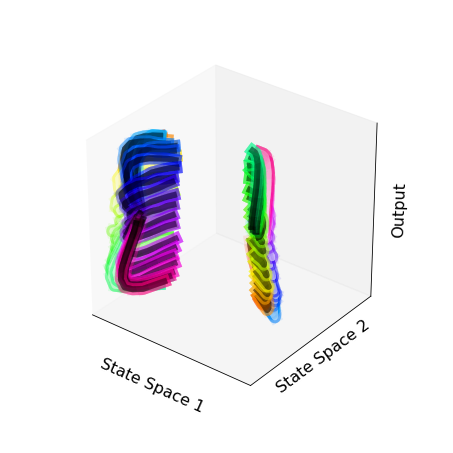

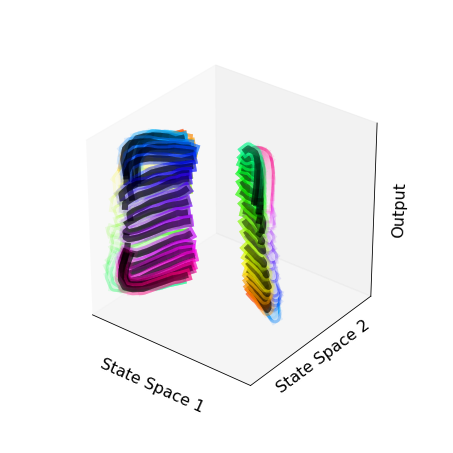

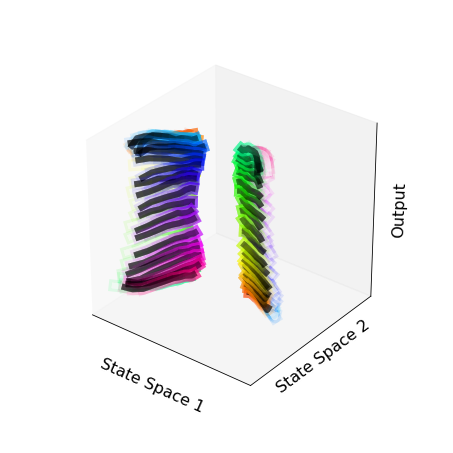

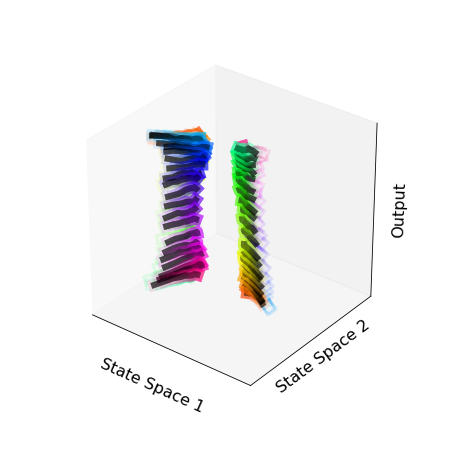

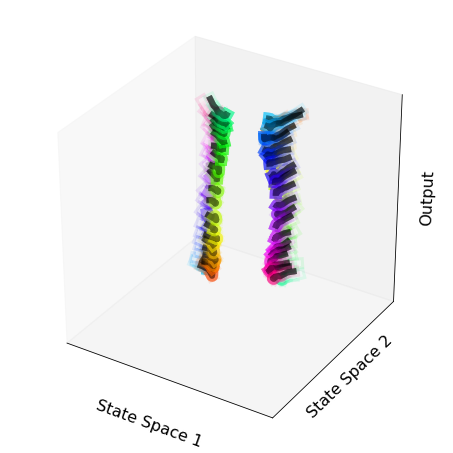

In [27]:
fig_size = 6
epoch_set = ['go1','go1']
script_name = 'interp_tasks_small_init_mov'

ax_labels = {}
ax_labels[0] = 'State Space 1'
ax_labels[1] = 'State Space 2'
ax_labels[2] = 'Output'

q_thresh = 1e-7

lim = 1.5
lims = [-lim,lim,-lim,lim,-1.1,1.1]

lims = bifurc_mov(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,threeD = True,
         n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1.05, 
              lims = lims, view_ang = [31,-52], plot_fps = False, n_trials = 40, bifurc = False)